In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.regularizers import l2

In [2]:
ratings = pd.read_csv('../base_dataset/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [3]:
user_ids = ratings['user_id'].unique().tolist()
movie_ids = ratings['movie_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['user_id'].map(user2user_encoded)
ratings['movie'] = ratings['movie_id'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

In [4]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
user_input = Input(shape=(1,), dtype='int32', name='user')
movie_input = Input(shape=(1,), dtype='int32', name='movie')

user_embedding = Embedding(output_dim=50, input_dim=num_users, input_length=1, name='user_embedding', embeddings_regularizer=l2(0.001))(user_input)
movie_embedding = Embedding(output_dim=50, input_dim=num_movies, input_length=1, name='movie_embedding', embeddings_regularizer=l2(0.001))(movie_input)

user_flatten = Flatten()(user_embedding)
movie_flatten = Flatten()(movie_embedding)

dot_product = Dot(axes=1)([user_flatten, movie_flatten])

dropout = Dropout(0.5)(dot_product)

dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dense2 = Dense(1, kernel_regularizer=l2(0.001))(dense1)

model = Model(inputs=[user_input, movie_input], outputs=dense2)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [6]:
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=5, verbose=1, validation_split=0.1)

Epoch 1/5
2250/2250 [==============================] - 6s 2ms/step - loss: 1.7061 - mae: 1.0477 - val_loss: 1.3001 - val_mae: 0.9583
Epoch 2/5
2250/2250 [==============================] - 5s 2ms/step - loss: 1.2739 - mae: 0.9439 - val_loss: 1.3058 - val_mae: 0.9488
Epoch 3/5
2250/2250 [==============================] - 5s 2ms/step - loss: 1.2741 - mae: 0.9440 - val_loss: 1.2996 - val_mae: 0.9537
Epoch 4/5
2250/2250 [==============================] - 5s 2ms/step - loss: 1.2735 - mae: 0.9438 - val_loss: 1.3021 - val_mae: 0.9507
Epoch 5/5
2250/2250 [==============================] - 5s 2ms/step - loss: 1.2729 - mae: 0.9440 - val_loss: 1.3000 - val_mae: 0.9523


In [7]:
model.save('..\\model\\ncf_model')

INFO:tensorflow:Assets written to: ..\model\ncf_model\assets


INFO:tensorflow:Assets written to: ..\model\ncf_model\assets


In [8]:
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
              'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('../base_dataset/ml-100k/u.item', sep='|', names=movie_cols, encoding='latin-1')

625/625 [==============================] - 1s 1ms/step
Test MSE: 1.26381603327911
Test MAE: 0.9398419483184814


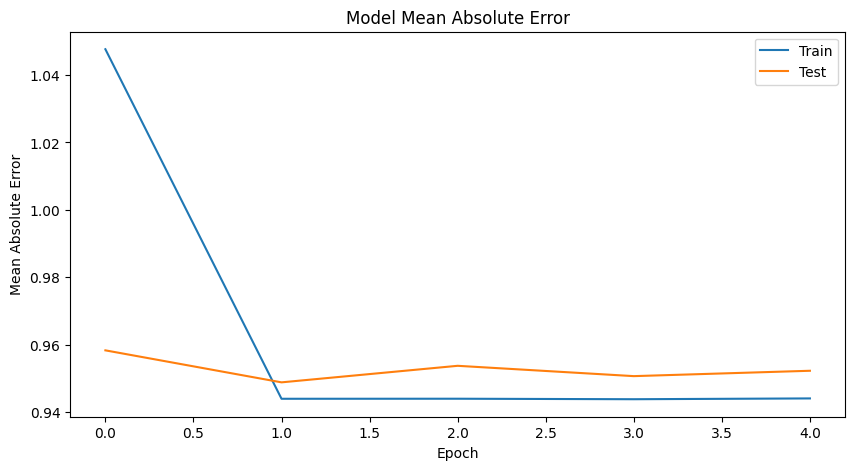

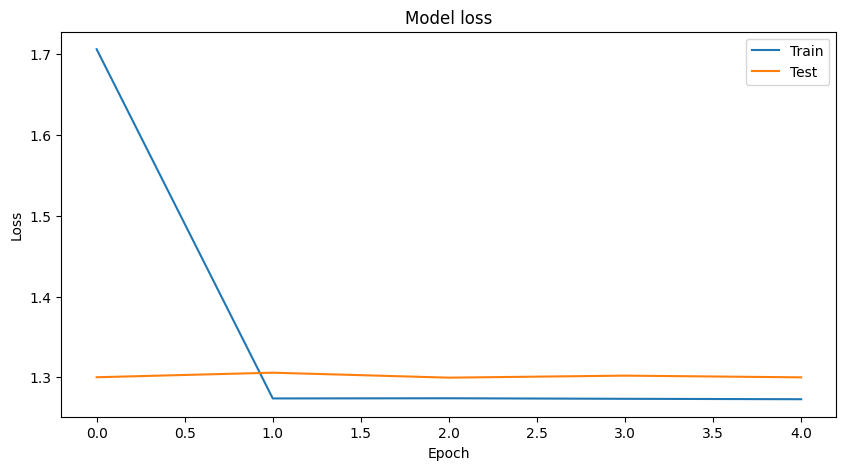

In [9]:
# Calculate prediction errors
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')

# Plot training & validation Mean Absolute Error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [12]:
def get_genres(row):
    return ', '.join([col for col in movie_cols[5:] if row[col]])

def transform_genres(movie):
    genres = []
    genre_mapping = {
        'unknown': 'unknown',
        'Action': 'Action',
        'Adventure': 'Adventure',
        'Animation': 'Animation',
        "Children's": '_10',
        'Comedy': 'Comedy',
        'Crime': 'Crime',
        'Documentary': 'Documentary',
        'Drama': 'Drama',
        'Fantasy': 'Fantasy',
        'Film-Noir': '_16',
        'Horror': 'Horror',
        'Musical': 'Musical',
        'Mystery': 'Mystery',
        'Romance': 'Romance',
        'Sci-Fi': '_21',
        'Thriller': 'Thriller',
        'War': 'War',
        'Western': 'Western'
    }
    for old_genre, new_genre in genre_mapping.items():
        if getattr(movie, new_genre):
            genres.append(old_genre)
    return ', '.join(genres)

def recommend_movies(user_id, num_recommendations):
    user = user2user_encoded[user_id]
    movies_not_watched = ratings[ratings['user_id']!=user_id]['movie_id'].unique()
    movies_not_watched = [movie2movie_encoded.get(x) for x in movies_not_watched]
    user_encoder = [user] * len(movies_not_watched)

    user_encoder = np.array(user_encoder).reshape(-1,1)
    movies_not_watched = np.array(movies_not_watched).reshape(-1,1)

    ratings_predicted = model.predict([user_encoder, movies_not_watched])

    top_ratings_indices = ratings_predicted.flatten().argsort()[-num_recommendations:][::-1]
    recommended_movie_ids = [movie_ids[i] for i in top_ratings_indices]
    recommended_ratings = [ratings_predicted[i][0] for i in top_ratings_indices]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        ratings[ratings['user_id'] == user_id]
        .sort_values(by="rating", ascending=False)
        .head(5)
        .movie_id.values
    )

    movie_df_rows = movies[movies["movie_id"].isin(top_movies_user)]

    for row in movie_df_rows.itertuples():
        print(row.title, ":", transform_genres(row))

    print("----" * 8)
    print("Top movie recommendations")
    print("----" * 8)
    recommended_movies = movies[movies["movie_id"].isin(recommended_movie_ids)]
    for idx, row in enumerate(recommended_movies.itertuples()):
        print(row.title, ": Predicted rating - ", recommended_ratings[idx], ", Genres - ", transform_genres(row))

In [ ]:
recommend_movies(user_id=2, num_recommendations=10)

In [ ]:
def print_user_ratings(user_id):
    user_movies = ratings[ratings['user_id'] == user_id].movie_id.values

    movie_df_rows = movies[movies["movie_id"].isin(user_movies)]

    for row in movie_df_rows.itertuples():
        user_rating = ratings[(ratings['user_id'] == user_id) & (ratings['movie_id'] == row.movie_id)].rating.values[0]
        print(row.title, ":", transform_genres(row), ":", user_rating)

user_id = 2
print(f"User {user_id}'s ratings:")
print_user_ratings(user_id)